# Feature Calculation and Normalization

## Prerequirements
This script assumes that you have calculated the baseline features in advance using the the following script "../Baseline Feature Caluculation/Baseline Calculation.py"

## Preprocessing in Biometric Data

The first step will be loading in the biomteric data and doing preprocessing on the whole data set (e.g. bandpass filtering EEG data). 

### Import Required Libraries:

In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import neurokit2 as nk
from pathlib import Path

### Load in Biometric Data
- Load in the CSV data exported from the Nexus-10 MKII.
- Drop the last row since it is empty

In [27]:
pID = "1"
nexus_data_p1_file_path = "Experiment Data/Participant "+pID+"/Experiment/Participant "+pID+" Experiment Data Nexus-10.csv"
print(nexus_data_p1_file_path)
nexus_data_p1 = pd.read_csv(nexus_data_p1_file_path, skiprows=11)

# Drop Last Row because it is empty
nexus_data_p1.drop(nexus_data_p1.tail(1).index,inplace=True)

Experiment Data/Participant 10/Experiment/Participant 10 Experiment Data Nexus-10.csv


# Set Sample Rate for each Sensors and Data

In [ ]:
DATA_SF = 256.
EEG_SF  = 256.
ECG_SF  = 256.
EDA_SF  = 32.
TEMP_SF = 32.

## Sync Timestamps with Interruption Data Set

### Biometric data set timestamps
The exported Nexus-10 MKII dataset uses relative timestamps. I need to extract the start date/time from the 5th and 6th line of the file. Using this start date, the rest of the timestamps are converted into milliseconds since unix epoch. The Start Time has a precision of seconds. Therefore the timewindows could be off by a maximum of +/-1s relative to the interruption.

Ideally the interruption event would have sent a trigger to the nexus device to record the exact point of interruption.

In [28]:
# Read File to extract start date and time
with open(nexus_data_p1_file_path, 'r') as filedata:
    linesList = filedata.readlines(256)
    nexusStartDateString = linesList[5]
    nexusStartTimeString = linesList[6]
    filedata.close()
    
# Filter and concatenate the datetime string
nexusStartDateString = nexusStartDateString[6:len(nexusStartDateString)-1]
nexusStartTimeString = nexusStartTimeString[6:len(nexusStartTimeString)-1]
nexusStartDateTimeString = nexusStartDateString + " " + nexusStartTimeString

# Format into datetime
format = '%Y-%m-%d %H:%M:%S'
dt = datetime.datetime.strptime(nexusStartDateTimeString, format)
# Convert from Datetime to Millis
millisec = int(dt.timestamp() * 1000)

# Calculate timestamps based on start datetime
timestamps = []
# Second to Millis = 1/1000
for n in range(0,len(nexus_data_p1)):
    timestamps.append(n*(1/DATA_SF*1000)+millisec)

# Store timestamps in original data set
nexus_data_p1['tsMillis'] = timestamps

### Convert Interruption Data Set Timestamps

For easier inspection after the experiment the interruption timestamps were displayed in a human readable format. For further processing, I will convert them to milliseconds since unix epoch.

In [29]:
#interruption_data_p1_file_path = "Experiment Data/Participant 1/Experiment/Interruption App test-participant1-1680098725468.csv"
interruption_data_p1_file_path = "Experiment Data/Participant "+pID+"/Experiment/Interruption App Data P"+pID+".csv"
#Interruption App Data P1.csv
interruption_data_p1 = pd.read_csv(interruption_data_p1_file_path,
    parse_dates=["tsStart"," tsEnd"])


tsStart_millis = []
for tsStart in interruption_data_p1['tsStart']:
    tsStart_millis.append(tsStart.timestamp() * 1000)

interruption_data_p1['tsStart_millis'] = tsStart_millis

# Add Binary Interruption Value
"For the two state classification we categorized data ratings from 1 (highly interruptible) to 5 (not at all interruptible) into two groups by labeling data with ratings of 1 to 3 as interruptible and ratings 4 and 5 as not interruptible."

In [30]:
interruption_data_p1["interruptible"] = interruption_data_p1[' interruptibility'] > 3

## Remove Duplicate Rows for Measures with lower Sampling Rate
Some of the measures (SCR,Temperature) were captured at a lower sampling rate of 32hz. In this step I remove the duplicate rows for those measures.

In [31]:
# Paticipant 10 was recorded at 1024hz
if pID == "10":
    nexus_data_p1 = nexus_data_p1.iloc[0::4].reset_index(drop=True)
    
nexus_data_p1_32 = nexus_data_p1.iloc[0::8]

## Filtering EEG Data

I filter the EEG Data to remove slow drift noise (below 0.1hz) and high frequency noise (above 100hz). In the literature sometimes the gamma band has no real upper bound, but is sometimes limited since the researches argue that high frequency noise is to large compared to the signal. \[REFERENCE MISSING\]

Replicating the original study the gamma band is defined as 30-80hz. I filter a bit above at 100hz. The literature advise to filter above the frequencies of interest to minimise artifacts caused at the boundaries of the filter. \[REFERENCE MISSING\] According to the manufacturer of hardware used in the original study (Neurosky Mindband) the raw EEG data exported is already pre-filtered 3-100hz. The relatively high highpass filter is probably due to using dry electrodes and low frequency drift/noise due to movement/perspiration. However, the delta band is almost completely filtered out with only frequencies 3-4hz being left, so it is not directly comparable to other studies investigating the full delta range. 

The original study uses a 50hz notch filter to remove mains hums. In a region with 60 cycle mains use a 60hz filter instead.

- Read EEG data
- Optional: Plot data to inspect it.
- Apply Bandpass filter (3hz-100hz)
- Apply 50hz/60hz Notch Filter

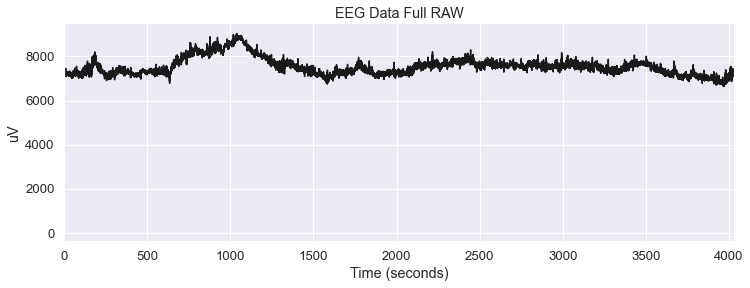

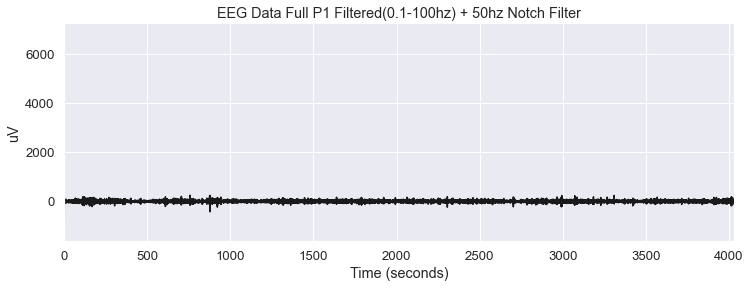

In [32]:
nexus_data_p1_eeg = nexus_data_p1['Sensor-A:EEG']

# Optional: plot the signal
data = nexus_data_p1_eeg
time = np.arange(data.size) / EEG_SF
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('uV')
plt.xlim([time.min(), time.max()])
plt.title('EEG Data Full RAW')
sns.despine()

# Create Filter: EEG (3 - 100 Hz) 5th order butterworth bandpass filter
fpass = [3, 100]
wpass = [fpass[0] / (EEG_SF / 2),fpass[1] / (EEG_SF / 2)]
b,a = signal.butter(5, wpass, "pass")
w, h = signal.freqz(b,a, fs = EEG_SF)
# Optional: Plot filter frequency response
# plt.plot(w, abs(h), label="order = %d" % 5)


# Filter the whole EEG Data and store it in the original data set
nexus_data_p1_filtered_step_1 = signal.filtfilt(b, a, nexus_data_p1_eeg)
nexus_data_p1['EEG-Filtered'] = signal.filtfilt(b, a, nexus_data_p1_filtered_step_1)


# 50hz Notch Filter to Remove Mains Hum 
# 2nd Order Butterworth Filter Bandstop:49-51hz
# Filtering 50hz mains hum
fstop = [49, 51]
# Uncomment for 60hz mains hum
# fstop = [59, 61]
wstop = [fstop[0] / (EEG_SF / 2),fstop[1] / (EEG_SF / 2)]
b,a = signal.butter(2, wstop, "stop")
w, h = signal.freqz(b,a, fs = EEG_SF)
# Optional: Plot filter frequency response
# plt.plot(w, abs(h), label="order = %d" % 2)

# Apply the 50hz notch filter to the filtered data set
nexus_data_p1['EEG-Filtered'] = signal.filtfilt(b, a, nexus_data_p1_filtered_step_1)

# Optional: plot the filtered signal
data = nexus_data_p1['EEG-Filtered']
time = np.arange(data.size) / EEG_SF
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('uV')
plt.xlim([time.min(), time.max()])
plt.title('EEG Data Full P1 Filtered(0.1-100hz) + 50hz Notch Filter')
sns.despine()

## Separate EEG Filtering for Blink Detection
For this Measure, I will apply a filter to focus on the relevant low frequency signal. \[REFERENCE MISSING\] 

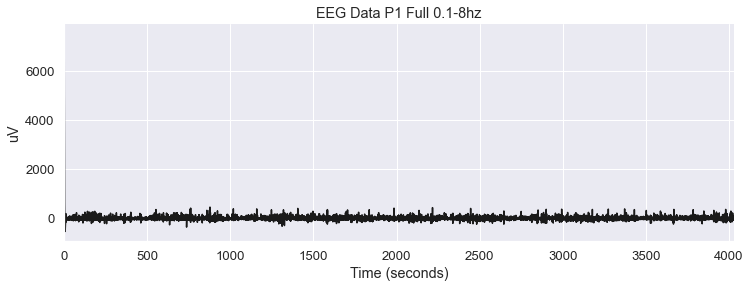

In [33]:
#---------------------------------------------------------------------
nexus_data_p1_eeg = nexus_data_p1['Sensor-A:EEG']

fpass = [0.1, 8]
wpass = [fpass[0] / (EEG_SF / 2),fpass[1] / (EEG_SF / 2)]
b,a = signal.butter(2, wpass, "pass")
w, h = signal.freqz(b,a, fs = EEG_SF)

#Optional: Plot Frequency Response 
# plt.plot(w, abs(h), label="order = %d" % 2)
# plt.xlim([0, 10])

#filter the full raw eeg data
nexus_data_p1['EEG-Filtered(0.1-8hz)'] = signal.filtfilt(b, a, nexus_data_p1_eeg)

# Plot the Filtered Data
data = nexus_data_p1['EEG-Filtered(0.1-8hz)']
time = np.arange(data.size) / EEG_SF
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('uV')
plt.xlim([time.min(), time.max()])
plt.title('EEG Data P1 Full 0.1-8hz')
sns.despine()

# Convert data to time-independent features

Once all the data has been filtered and the timestamps are in the correct format, I can calculate the time-independent features (e.g. band power, max, mean) that are going to be used in the ML algorithms.

Replicating the original study, I am going to use the following time windows:
- 10s
- 20s
- 30s
- 45s
- 1m
- 2m
- 3m

Due to my process, I have to check if there was enough time (>largest time window: 3min) between starting the recording and the first interruption.

For each timewindow the follwing metrics are calculated:
- EEG:
    - Calculate Bandpowers (θ,δ,α,β,γ) for each time
    - Eye Blink Rate (derived from EEG artifacts)
- EDA (Measurement Errors in Data Set)
    - SCL (Tonic EDA)
    - Peaks per time unit (Phasic EDA)
    - Mean Peak Amplitudes
    - Sum of Peak Amplitudes
    - AUC
- ECG (BVP in original study)
    - Peaks per time unit (Heart Rate?)
    - Mean Peak Amplitude
    - Heart Rate:
        - Mean
        - Variance
    - IBI
        - SDNN
        - PNN20
        - PNN50

## Define Timewindows and Select Subsamples

In [34]:
# Time Windows from the Original Study:
time_windows_in_seconds = [10,20,30,45,1*60,2*60,3*60]
time_window_in_seconds = time_windows_in_seconds[0]
ts1 = interruption_data_p1['tsStart_millis'][0]


#time_window_p1_i1 = nexus_data_p1[(nexus_data_p1['tsMillis'] <= ts1) &
#                    (nexus_data_p1['tsMillis'] >= ts1-time_window_in_seconds*1000)] 
    

# Check if there is enough time between start and first interruption
if not ((ts1-nexus_data_p1['tsMillis'][0]-3*60*1000) > 0):
    print("Warning!: Less than 3 Min of Data for the first Time Window!")

data =  nexus_data_p1
timewindowed_subsamples = {}
interruption_data_tw = {}
data_32 =  nexus_data_p1_32 # repeated for 32hz sampled data
timewindowed_subsamples_32 = {} # repeated for 32hz sampled data
for ts in time_windows_in_seconds:
    # Add the Interruption App Data Set to each Time Window Slot
    interruption_data_tw[str(ts)] = interruption_data_p1.copy()
    subsample = []
    subsample_32 = []
    for interruption_timestamp in interruption_data_p1['tsStart_millis']:
        subsample.append(data[(data['tsMillis'] <= interruption_timestamp) &
                        (data['tsMillis'] >= interruption_timestamp-ts*1000)])
        # repeated for 32hz sampled data
        subsample_32.append(data_32[(data_32['tsMillis'] <= interruption_timestamp) &
                        (data_32['tsMillis'] >= interruption_timestamp-ts*1000)])
    timewindowed_subsamples[str(ts)] = subsample
    # repeated for 32hz sampled data
    timewindowed_subsamples_32[str(ts)] = subsample_32

## EEG Metrics
### Bandpower
To calculate the bandpowers of the signal I will use the method from \[AUTHOR\] great blog article. \[REFERENCE MISSING\]

In [35]:
# Method from: https://raphaelvallat.com/bandpower.html
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.
        
    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band
    
    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf
        
    # Compute the modified periodogram (Welch) (ADAPTED FOR THE REPLICATION)
    # Emulating Matlab pwelch() default behavior of splitting into 8 segments
    # See: https://dsp.stackexchange.com/questions/84193/why-does-python-welch-give-me-a-different-answer-from-matlabs-pwelch
    N = np.floor(len(data)/8)
    # Setting detrend=False
    # Explanation https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
    freqs, psd = welch(data, sf, nperseg=N,detrend=False)
    #freqs, psd = welch(data, sf, nperseg=nperseg,detrend=False)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    
    
    
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)
    
    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

I compute the absolute bandpower for all bands used in the original study. Then all possible combinations of fractions are computed. Additionally these two ratios are computed: θ/(α + β) and β/(α + θ).

In [37]:
# data = data[time_window]
for tw in time_windows_in_seconds:
    time_window = str(tw)
    tw_subsamples = timewindowed_subsamples[time_window]

    bandpower_data = []
    for tw_subsample in tw_subsamples:
        data = tw_subsample['EEG-Filtered']
        win_sec = 4
        bandpowers = {}
        # Delta
        bandpowers["delta"] = bandpower(data,EEG_SF,[0.5,4],win_sec,relative=False)
        # Theta
        bandpowers["theta"] = bandpower(data,EEG_SF,[4,8],win_sec,relative=False)
        # Alpha
        bandpowers["alpha"] = bandpower(data,EEG_SF,[8,12],win_sec,relative=False)
        # Beta
        bandpowers["beta"] = bandpower(data,EEG_SF,[12,30],win_sec,relative=False)
        # Gamma
        bandpowers["gamma"] = bandpower(data,EEG_SF,[30,100],win_sec,relative=False)
        
        # Calculate fractions of all combinations of frequency bands
        bands = list(bandpowers.keys())
        for band in bands:
            for other_band in bands:
                if band!=other_band:
                    bandpowers[band+"/"+other_band] = bandpowers[band]/bandpowers[other_band]

        # Calculate θ/(α + β) and β/(α + θ)
        bandpowers["theta/(alpha+beta)"] = bandpowers["theta"] / (bandpowers["alpha"]+bandpowers["beta"])
        bandpowers["beta/(alpha+theta)"] = bandpowers["beta"] / (bandpowers["alpha"]+bandpowers["theta"])

        bandpower_data.append(bandpowers)
        #for bandname, bandpower in bandpowers.items():
       #     measurement_string = bandname+"_tw_"+time_window
         #   tw_subsample_measurement_data[measurement_string] = bandpower

    # Add Bandpower data to interruption data set
    bandpower_data_df = pd.DataFrame.from_dict(bandpower_data)
    # print(df)

    interruption_data_tw[time_window] = pd.concat([interruption_data_tw[time_window].reset_index(drop=True),bandpower_data_df.reset_index(drop=True)], axis=1)
    # print(interruption_data_tw[time_window])

{'delta': 16.27845470173312, 'theta': 40.28752763090759, 'alpha': 9.137005376330112, 'beta': 60.918269039677476, 'gamma': 167.6797480496297}
{'delta': 26.323184882132804, 'theta': 54.2297775324919, 'alpha': 21.93343018101431, 'beta': 41.605116775365815, 'gamma': 122.88755081502488}
{'delta': 43.04200576106049, 'theta': 65.23159009066882, 'alpha': 13.293327693968106, 'beta': 25.09013323332077, 'gamma': 69.14467003818969}
{'delta': 12.631234753513233, 'theta': 25.613735197110685, 'alpha': 21.833588739275328, 'beta': 60.724030574415075, 'gamma': 100.79911900210168}
{'delta': 53.86202656504384, 'theta': 116.70547755947487, 'alpha': 21.581170192754133, 'beta': 36.37036391593588, 'gamma': 98.75901171709013}
{'delta': 9.931713173758743, 'theta': 24.138340877677557, 'alpha': 9.951687678163648, 'beta': 27.795205087086213, 'gamma': 57.25143606976631}
{'delta': 20.8333241085702, 'theta': 29.17499249726203, 'alpha': 12.987860953518721, 'beta': 51.45436931238384, 'gamma': 89.9581878292906}
{'delta'

### Eye Blinks



In [38]:
# data = data[time_window]
for tw in time_windows_in_seconds:
    time_window = str(tw)
    tw_subsamples = timewindowed_subsamples[time_window]

    eye_blink_data = []
    for tw_subsample in tw_subsamples:
        data = tw_subsample['EEG-Filtered(0.1-8hz)']
        # PEAK FINDING Algorithm (tweaking parameters (e.g. prominence, height) unknown)
        peaks = np.array(signal.find_peaks(data,prominence=100,height=50)[0])
        # print(peaks)
        num_of_blinks = len(peaks)
        eye_blink_data.append(num_of_blinks)
#        # Optional: Plot the Peaks
#        time = np.arange(data.size) / EEG_SF
#        # Plot the signal
#        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#        plt.plot(time, data, lw=1.5, color='k')
#        plt.axhline(y=0, color='r', linestyle='-')
#        plt.xlabel('Time (seconds)')
#        plt.ylabel('uV')
#        #plt.xlim([time.min(), time.max()])
#        plt.xlim([time.min(), time.max()])
#        plt.plot(peaks/EEG_SF, np.array(data)[peaks], "xr")
#        plt.legend(['peaks'])
#        plt.title('EEG Data P1 Full 2-3hz')
#        sns.despine()
    interruption_data_tw[time_window]['num_of_blinks'] = eye_blink_data

## ECG Metrics
Due to differences in hardware, for the replication I was using ECG instead of BVP (aka PPG). Both are used to derrive heart related features, with the former being the more reliable data source. Therefore, in my code I feature ECG Data Processing. 

The [NeuroKit2](https://neuropsychology.github.io/NeuroKit/index.html) Library has processing pipelines for both [ECG](https://neuropsychology.github.io/NeuroKit/functions/ecg.html) data, aswell as [BVP](https://neuropsychology.github.io/NeuroKit/functions/ppg.html) data.

Alternatevly, I would recommend using the [HeartPy](https://github.com/paulvangentcom/heartrate_analysis_python) library, since it also has algorithms specific to dealing with noisy BVP data. 


Below you can see a comparison of the quality of ECG and BVP data as shown in the HeartPy documentation:

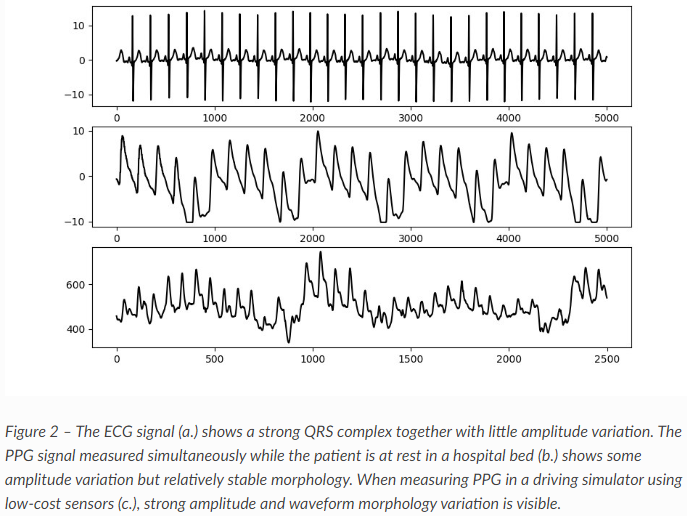
[Source: HeartyPy Documentation](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/heartrateanalysis.html)

In my Code I used the NeuroKit2 pipline for data cleaning and peak finding. Cleaning the data involves a highpass filter with a 0.5hz cutoff (4th Order Butterworth Filter) plus a 50hz notch filter. The r-peak finding algorithm is BioPeak [REFERENCE NEEDED].

In [39]:
# data = data[time_window]
for tw in time_windows_in_seconds:
    time_window = str(tw)
    tw_subsamples = timewindowed_subsamples[time_window]

    mean_hr_data = []
    variance_hr_data = []
    max_peak_amplitude_data = []
    num_of_peaks_data = []
    sum_peak_amplitude_data = []
    num_of_peaks_data = []
    sdnn_data = []
    pnn20_data = []
    pnn50_data = []
    for tw_subsample in tw_subsamples:
        ecg_signal = tw_subsample['Sensor-B:ECG/EKG']
        #peaks = signal.find_peaks(ecg_signal,prominence=1000)[0]
        ecg_signals, ecg_info = nk.ecg_process(ecg_signal, sampling_rate=256)
        #print(ecg_info)
        peaks = ecg_info['ECG_R_Peaks']
        peak_onsets = np.where(ecg_signals['ECG_R_Onsets'] == 1)[0]
        
        rri = np.diff(peaks) / ECG_SF * 1000
        clean_ecg_signal = ecg_signals['ECG_Clean']
        peak_vals = clean_ecg_signal.iloc[peaks].reset_index(drop=True)
        onset_vals = clean_ecg_signal.iloc[peak_onsets].reset_index(drop=True)
        amplitudes = np.subtract(peak_vals,onset_vals)
        
        #DEBUG------------------------------------------------
 #       data = ecg_signals['ECG_Clean']
  #      peaks = ecg_info['ECG_R_Peaks']
#
 #       peak_onsets = np.where(ecg_signals['ECG_R_Onsets'] == 1)[0]
   #     time = np.arange(data.size) / EEG_SF
    #    # Plot the signal
     #   fig, ax = plt.subplots(1, 1, figsize=(12, 4))
      #  plt.plot(time, data, lw=1.5, color='k')
       # plt.xlabel('Time (seconds)')
        #plt.ylabel('uV')
        # Optionally inspect smaller subset
#        # plt.xlim([sample_start_in_seconds, sample_end_in_seconds])
 #       plt.plot(peaks/EEG_SF, data[peaks], "xr")
  #      plt.plot(peak_onsets/EEG_SF, data[peak_onsets], "xg")
#
 #     #  plt.vlines(x = peaks/EEG_SF, ymin = data[peak_onsets], ymax = data[peaks],
  #     #            colors = 'purple',
   #     #           label = 'peak-peak_onset ~ r peak amplitude')
#
 #       plt.xlim([time.min(), time.max()])
  #      plt.title('ECG Data Clean')
   #     sns.despine()
        #DEBUG------------------------------------------------
        
        # Calculate Features
        # TODO: Here NK2 uses interpolation for the heart rate calcualtion
        mean_hr_in_bpm = 60000/(np.mean(rri))

        max_peak_amplitude = max(peak_vals)
        mean_peak_aplitude = np.mean(peak_vals)
        sum_peak_amplitude = sum(peak_vals)
        num_of_peaks = len(peaks)
        
        hr_variance_in_bpm = 60000/(np.var(rri,ddof=1))
        sdnn = np.std(rri,ddof=1)

        diff_rri = abs(np.diff(rri))

        nn50 = np.sum(np.abs(diff_rri) > 50)
        nn20 = np.sum(np.abs(diff_rri) > 20)
        pnn50 = nn50 / (len(diff_rri) + 1) * 100
        pnn20 = nn20 / (len(diff_rri) + 1) * 100
        
        
        
        mean_hr_data.append(mean_hr_in_bpm)
        variance_hr_data.append(hr_variance_in_bpm)
        max_peak_amplitude_data.append(max_peak_amplitude)
        num_of_peaks_data.append(num_of_peaks)
        sum_peak_amplitude_data.append(sum_peak_amplitude)
        sdnn_data.append(sdnn)
        pnn20_data.append(pnn20)
        pnn50_data.append(pnn50)

    interruption_data_tw[time_window]['mean_hr_in_bpm'] = mean_hr_data
    interruption_data_tw[time_window]['hr_variance_in_bpm'] = variance_hr_data
    interruption_data_tw[time_window]['max_peak_amplitude'] = max_peak_amplitude_data
    interruption_data_tw[time_window]['num_of_peaks'] = num_of_peaks_data
    interruption_data_tw[time_window]['sum_peak_amplitude'] = sum_peak_amplitude_data
    interruption_data_tw[time_window]['sdnn'] = sdnn_data
    interruption_data_tw[time_window]['pnn20'] = pnn20_data
    interruption_data_tw[time_window]['pnn50'] = pnn50_data

C:\Users\alerr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


## EDA Metrics
Due to a measurement error, most of the EDA Data is unusable shownig no response. The most likely cause was the use of the wrong kind of electrodes. My setup used EEG/ECG electrodes which use a non-isotonic gel, the higher salt content could oversaturate the sweat glands leading to no skin response ([Publication recommendations for electrodermal measurements](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-8986.2012.01384.x)). Additionally, for some participant the electrodes did not form a connection leading to no signal. However, the lack of signal could also be explained by a number of different factors (see [Improving Data Quality: EDA](https://support.mindwaretech.com/2017/12/improving-data-quality-eda/)).

Surprisingly the Data from the 9th participant resembled usable EDA Data, as in featuring enough phasic and tonic activity. So using this data and also using some simulated EDA data the Data Processing Steps were replicated. However these features were not used for consequent the machine learning part.

The Original Papers first filters out noise in the EDA data by applying an exponential filter. The exact alpha value used was not specified. It is unclear wether this filtering is really necessary. For example, the eda_clean() function of the Neurokit2 Library does not filter data with a sampling rate lower than 7hz since high frequency noise should not be captured by such a slow sensor. The original study used a 4hz sampling rate so the same should apply there.

The exact alpha value used for the filtering was not sepcified. In another paper an alpha value of 0.8 was used ([Herndanez et al. 2011](https://link.springer.com/chapter/10.1007/978-3-642-24600-5_16)). However, in my data only  values smaller than 0.2 resulted in visible smoothing. The Neurokit2 Library uses a 4th Order Butterworth low pass filter with a 3hz cutoff instead for cleaning.

To split the data into tonic and phasic components a butterworth filter is used. This is also the default for the Neurokit2 library. The frequency cutoff is not defined for the original paper. The neurokit library uses a 0.05hz cutoff by default. This adapts the method for splitting tonic and phasic components implemented in Biopac's acqknowledge software. I assume this is what the original authors meant by saying "we used a Butterworth filter to split the EDA signal into its tonic and phasic part."

Extra: When using the Neurokit eda_process function to find SCR peaks, using short windows (10-30s) like in the original study may lead to strange behavior. During times of no activity it will detect peaks as in the signal as it does not use thresholding for the peak detection. 
As an example, below i have plotted a 20 second sample (with no activity) where small peaks (probably noise) are detected as SCR Peaks.

20sec:

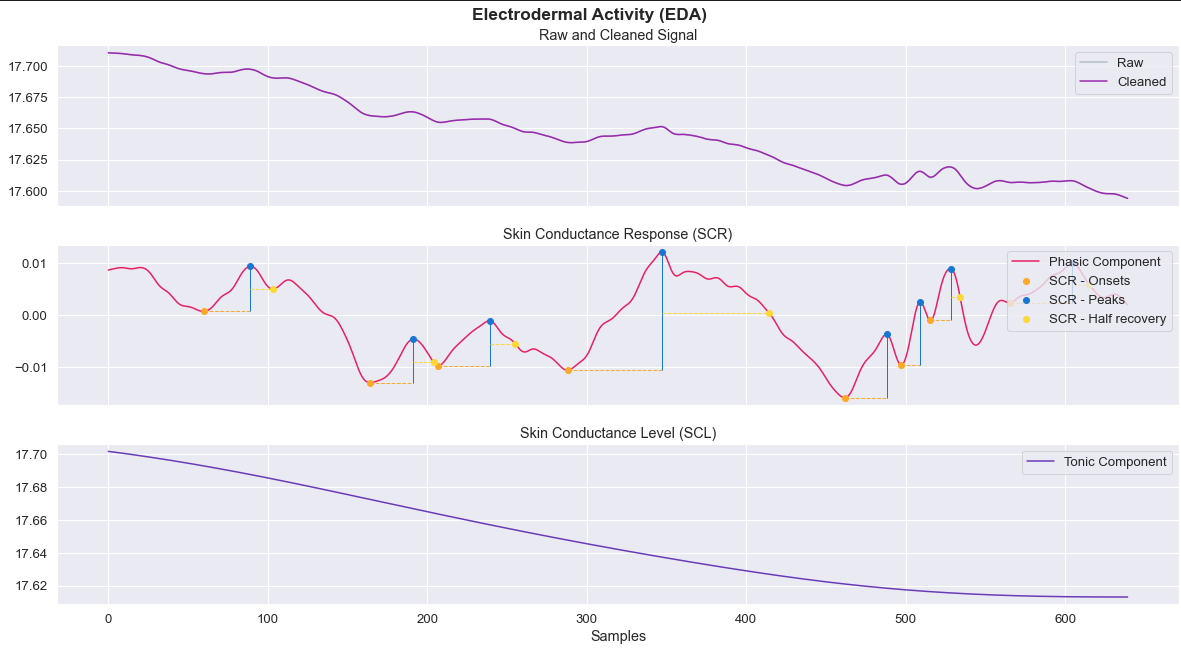

In [ ]:
import warnings

for tw in time_windows_in_seconds:
    time_window = str(tw)
    # NOTE: Using the 32hz Data Set for SCR
    tw_subsamples = timewindowed_subsamples_32[time_window]

    peaks_per_time_unit_data = []
    mean_peak_amplitudes_data = []
    sum_peak_amplitudes_data = []
    mean_scl_data = []
    auc_data = []
    for tw_subsample in tw_subsamples:
        eda_signal = tw_subsample['Sensor-E:SC/GSR']
        
        eda_signal = eda_signal.reset_index(drop=True)
        
        # Smoothing Step from Original Study
#        with warnings.catch_warnings():
#            warnings.simplefilter("ignore")
#            eda_signal = SimpleExpSmoothing(eda_signal).fit(
#                smoothing_level=0.15).fittedvalues

        signals, info = nk.eda_process(eda_signal, sampling_rate=EDA_SF)
        
        # Optional: Plot Processed EDA Signal
        # This produced errors in my testing
        # ValueError: Length of values (2) does not match length of index (3)
#        try:
#            eda_plot = nk.eda_plot(signals)
#            eda_plot.set_size_inches(18.5, 10.5)
#            eda_plot
#        except ValueError:
#            print("EDA Plot Value Error")

        peaks_per_time_unit = len(info['SCR_Peaks'])
        mean_peak_amplitudes = np.mean(info['SCR_Amplitude'])
        sum_peak_amplitudes = np.sum(info['SCR_Amplitude'])
        mean_scl = np.mean(signals['EDA_Tonic'])
        auc = np.sum(signals['EDA_Phasic'])*sf
            
        
        peaks_per_time_unit_data.append(peaks_per_time_unit)
        mean_peak_amplitudes_data.append(mean_peak_amplitudes)
        sum_peak_amplitudes_data.append(sum_peak_amplitudes)
        mean_scl_data.append(mean_scl)
        auc_data.append(auc)


    #print(time_window)
    interruption_data_tw[time_window]['scr_peaks_per_time_unit'] = peaks_per_time_unit_data
    interruption_data_tw[time_window]['mean_scr_peak_amplitudes'] = mean_peak_amplitudes_data
    interruption_data_tw[time_window]['sum_scr_peak_amplitudes'] = sum_peak_amplitudes_data
    interruption_data_tw[time_window]['mean_scl'] = mean_scl_data
    interruption_data_tw[time_window]['scr_auc'] = auc_data


## Temperature Metrics

The original papers mentions "amplitude features", I could not find any reference how to interpret this exactly. For the reproduction I assume the author meant mean and max of the signal level.

In [40]:
for tw in time_windows_in_seconds:
    time_window = str(tw)
    # NOTE: Using the 32hz Data Set for SCR
    tw_subsamples = timewindowed_subsamples_32[time_window]

    mean_temp_data = []
    max_temp_data = []
    for tw_subsample in tw_subsamples:
        temp_signal = tw_subsample['Sensor-F:Temp.']
                
        mean_temp = np.mean(temp_signal)
        max_temp = np.max(temp_signal)
        
        mean_temp_data.append(mean_temp)
        max_temp_data.append(max_temp)


    #print(time_window)
    interruption_data_tw[time_window]['mean_temp'] = mean_temp_data
    interruption_data_tw[time_window]['max_temp'] = max_temp_data


# Optional: Save Data Set
Save data set as csv.. 

# Repeat the Processing for all Participants (TODO)

# Normalization
## 1. Calculate Baseline Features for alle Participants
This is done in a separate baseline.py file. It calculates the features in the same way as described here but using a 100s sample of the baseline data set. Due Artifacts from Starting/Stopping the Recording I could not use the full 2 minutes as in the Original Paper. In the Original Paper the Recording was started once and Basline Data and Session Data were extracted using Timestamps. In my case I started/stopped recording for each the baselining and the main experiment. In hindsight, this was a mistake (and if the resulting data would not be too large) starting the recording once would be preferable.
## 2. Subtract Baseline Values from Interruption Data Set
As described in the original paper, normalizing the data sets across participants is done by subtracting each feature values by the feature values calculated from the baseline.
When researching normalization a more common approach I found was to use the z-score based on the baseline (REFERENCE?).

In [41]:
import pickle

file_name = "baseline_p" + pID
with open(file_name+'.pkl', 'rb') as fp:
    baseline_data = pickle.load(fp)

normalized_interruption_data_tw = {}
for key, interruption_data in interruption_data_tw.items():
    normalized_interruption_data_tw[key] = interruption_data.copy()
for tw, interruption_data in normalized_interruption_data_tw.items():
    for key, measure in baseline_data.items():
        #print(key)
        #print(interruption_data)
        interruption_data[key] = interruption_data[key]-measure
        


## 3. Save Datasets

In [42]:
for key, interruption_data in normalized_interruption_data_tw.items():
        absolute_path = 'C:/Users/alerr/Documents/Masterarbeit'
        dir_name = absolute_path + "/Normalized Data/"+ key + "/"
        Path(dir_name).mkdir(parents=True, exist_ok=True)
        file_name = dir_name+ "normalized_interruption_data_p" + pID + "_tw_" + key + "s_3hz.csv"
        print(file_name)
        interruption_data.to_csv(file_name,index=False)
        
for key, interruption_data in interruption_data_tw.items():
        absolute_path = 'C:/Users/alerr/Documents/Masterarbeit'
        dir_name = absolute_path + "/Individual Data/"+ key + "/"
        Path(dir_name).mkdir(parents=True, exist_ok=True)
        file_name = dir_name+ "individual_interruption_data_p" + pID + "_tw_" + key + "s_3hz.csv"
        print(file_name)
        interruption_data.to_csv(file_name,index=False)

C:/Users/alerr/Documents/Masterarbeit/Normalized Data/10/normalized_interruption_data_p10_tw_10s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/20/normalized_interruption_data_p10_tw_20s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/30/normalized_interruption_data_p10_tw_30s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/45/normalized_interruption_data_p10_tw_45s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/60/normalized_interruption_data_p10_tw_60s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/120/normalized_interruption_data_p10_tw_120s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Normalized Data/180/normalized_interruption_data_p10_tw_180s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Individual Data/10/individual_interruption_data_p10_tw_10s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Individual Data/20/individual_interruption_data_p10_tw_20s_3hz.csv
C:/Users/alerr/Documents/Masterarbeit/Individual Da

In [43]:
# REPEAT STEPS FOR EACH PARTICIPANT

## 4. Combine Data Sets

In [7]:
timewindows_in_seconds = [10,20,30,45,1*60,2*60,3*60]
pIDs= range(1,11)
absolute_path = 'C:/Users/alerr/Documents/Masterarbeit'

for tw in timewindows_in_seconds:
    aggregate_df = None
    for pID in pIDs:
        path = "Normalized Data/"+str(tw)+"/normalized_interruption_data_p"+str(pID)+"_tw_"+str(tw)+"s_3hz.csv"
        data = pd.read_csv(path)
        data["pID"] = str(pID)
        if aggregate_df is None:
            aggregate_df = data
        else:
            aggregate_df = pd.concat([aggregate_df,data],ignore_index=True)

    dir_name = absolute_path + "/Normalized Data/"+str(tw)+"/with_pID/"
    Path(dir_name).mkdir(parents=True, exist_ok=True)
    aggregate_df.reset_index(drop=True)
    aggregate_df.to_csv("Normalized Data/"+str(tw)+"/with_pID/normalized_interruption_data_ALL_tw_"+str(tw)+"s_pID_3hz.csv",index=False)
